In [ ]:
import argparse
import os
import random

import numpy as np
import numpy.matlib

import matplotlib.pyplot as plt
import pickle

## Dataset overview

In this problem we are building 15-way multi-class classifiers for a fruit classification task. The training and validation sets are stored in the .pkl files provided. See the hw5.pdf file we have provided for details.

In each dataset, we provide the following:
- 'images': the raw RGB images
- 'feats': 15 dimensional condensed representations of each image (that were precomputed by using a pretrained vision transformer + PCA)
- 'labels': an integer value between 0 and 14. The integer to class mapping is provided below in the variable 'idx_to_class'.

We first create a simple python dictionary that maps integers to textual class labels that can be useful for debugging.

In [ ]:
idx_to_class = {0: 'Apple', 1: 'Banana', 2: 'Carambola', 3: 'Guava', 4: 'Kiwi', 5: 'Mango', 6: 'Orange', 7: 'Peach', 8: 'Pear', 9: 'Persimmon', 10: 'Pitaya', 11: 'Plum', 12: 'Pomegranate', 13: 'Tomatoes', 14: 'Muskmelon'}
print(idx_to_class)

Next, we load the .pkl files that load as python dictionaries.

In [3]:
with open('train.pkl', 'rb') as f:
    train_dataset = pickle.load(f)

In [4]:
with open('val.pkl', 'rb') as f:
    val_dataset = pickle.load(f)

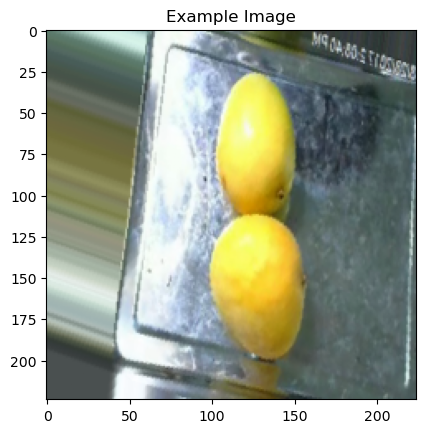

In [5]:
# We can plot the images this way. This will be quite useful for debugging.
plt.figure()
plt.title('Example Image')
plt.imshow(train_dataset['images'][0])
plt.show()

In [6]:
print("Examples Features shape:", train_dataset['feats'][0].shape)

Examples Features shape: (15,)


In [7]:
print("Example image label:", idx_to_class[train_dataset['labels'][0]])

Example image label: Mango


In [ ]:
#BAKEOFFF

In [ ]:
pred = []

# TODO: Train a classifier and generate predictions on the test set and put your predictions in pred.
# ...

# Make sure that pred contains a 1-dimensional integer array of class labels for the test set and make sure that
# every integer is in the range 0 through 14. If you have an entry in this array outside of the integer
# range of 0 through 14, it will be assumed to be an error. Also, if your array is not the length of the test
# set that will be assumed to be an error. Specifically, suppose n_mine is the length of the array of integers
# you turn in. If the test set has n_test images (meaning 
# it is an n_test X m matrix), then if your array is less than n_test long (so n_mine < n_test, then any missing 
# images will be assumed to be an error, so there will be n_test - n_mine errors. If your array is longer than 
# n_test images long, so that n_mine > n_test, then we will take the final n_mine - n_test images, whatever
# your predictions are for those images, and assume that those n_mine - n_test images are in error. Bottom line:
# make sure your array is exactly the right length, meaning you should have n_mine == n_test. Meaning,
# the array pred should be a one-dimensional integer array with integers in the 0-14 range
# of length n_mine. You can make sure that pred is of integer type by doing `pred = pred.astype(np.int32)` but
# after you do this, make sure to examine the result to ensure that they are integers in the right range.
#
# Note that the saved text file should have one prediction per ASCII line (this can be done by ensuring that pred 
# is of shape (n_test,) and then simply using np.savetxt).
np.savetxt('test_predictions.txt', pred)


CROSS-VALIDATION

In [ ]:
import pickle
import numpy as np
from sklearn.model_selection import KFold
import tensorflow as tf

# Load pickle files
with open('train.pkl', 'rb') as f:
    train_data = pickle.load(f)

with open('val.pkl', 'rb') as f:
    dev_data = pickle.load(f)
BATCH_SIZE = 32
# Merge train and dev data
images = np.concatenate([train_data['images'], dev_data['images']])
labels = np.concatenate([train_data['labels'], dev_data['labels']])

# Define number of folds for cross-validation
n_folds = 5

# Initialize cross-validation splitter
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Loop through each fold
for i, (train_index, val_index) in enumerate(kf.split(images)):
    print(f"Fold {i+1}")
   
    # Get images and labels for current fold
    train_images, train_labels = images[train_index], labels[train_index]
    val_images, val_labels = images[val_index], labels[val_index]
   
    # Create datasets for current fold
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    train_dataset = train_dataset.shuffle(buffer_size=len(train_images))
    train_dataset = train_dataset.batch(BATCH_SIZE)
    train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    validation_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
    validation_dataset = validation_dataset.batch(BATCH_SIZE)
    validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

# Define batch size and image size
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# Get class names
class_names = list(idx_to_class.values())

# Load the base model
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

# Freeze the base model
base_model.trainable = False

# Add custom head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(class_names))

# Build the model
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the model
initial_epochs = 10

history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset
)

# Fine-tune the model
base_model.trainable = True
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
    metrics=['accuracy']
)

fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_dataset
)


# Evaluate the model on the train and validation datasets
train_loss, train_acc = model.evaluate(train_dataset)
val_loss, val_acc = model.evaluate(validation_dataset)

print('Train accuracy:', train_acc)
print('Validation accuracy:', val_acc)

# Compute precision, recall, and F1-score
from sklearn.metrics import classification_report

train_pred = np.argmax(model.predict(train_dataset), axis=-1)
train_true = train_labels
print("Train classification report:\n", classification_report(train_true, train_pred, digits=4))

val_pred = np.argmax(model.predict(validation_dataset), axis=-1)
val_true = val_labels
print("Validation classification report:\n", classification_report(val_true, val_pred, digits=4))



BAKE-OFF

In [8]:
import pickle
import numpy as np
import tensorflow as tf

# Load pickle files
with open('train.pkl', 'rb') as f:
    train_data = pickle.load(f)

with open('val.pkl', 'rb') as f:
    val_data = pickle.load(f)

with open('test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

# Merge train and validation data
train_images = np.concatenate([train_data['images'], val_data['images']])
train_labels = np.concatenate([train_data['labels'], val_data['labels']])

# Get test images
test_images = test_data['images']

# Define batch size and image size
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# Get class names
class_names = list(idx_to_class.values())

# Load the base model
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

# Freeze the base model
base_model.trainable = False

# Add custom head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(class_names))

# Build the model
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the model on train and validation data
initial_epochs = 10

history = model.fit(
    train_images, train_labels,
    epochs=initial_epochs,
    batch_size=BATCH_SIZE,
    validation_split=0.01
)

# Fine-tune the model
base_model.trainable = True
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
    metrics=['accuracy']
)

fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_images, train_labels,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    batch_size=BATCH_SIZE,
    validation_split=0.01
)


# Evaluate the model on the train and validation datasets
train_loss, train_acc = model.evaluate(train_dataset)
print('Train accuracy:', train_acc)

# Generate predictions for test images
test_predictions = model.predict(test_images)
test_predictions = np.argmax(test_predictions, axis=-1)

# Save predictions to file
np.savetxt('test_predictions.txt', test_predictions)

Epoch 1/10


/Users/harsheetav/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2023-03-17 13:10:12.942513: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


371/371 [==============================] - 92s 246ms/step - loss: 1.8359 - accuracy: 0.4634 - val_loss: 0.9823 - val_accuracy: 0.7417
Epoch 2/10
371/371 [==============================] - 87s 234ms/step - loss: 0.8385 - accuracy: 0.7742 - val_loss: 0.5665 - val_accuracy: 0.8583
Epoch 3/10
371/371 [==============================] - 90s 241ms/step - loss: 0.5554 - accuracy: 0.8527 - val_loss: 0.4057 - val_accuracy: 0.9250
Epoch 4/10
371/371 [==============================] - 88s 237ms/step - loss: 0.4208 - accuracy: 0.8907 - val_loss: 0.3087 - val_accuracy: 0.9250
Epoch 5/10
371/371 [==============================] - 90s 241ms/step - loss: 0.3385 - accuracy: 0.9140 - val_loss: 0.2493 - val_accuracy: 0.9500
Epoch 6/10
371/371 [==============================] - 89s 239ms/step - loss: 0.2833 - accuracy: 0.9292 - val_loss: 0.2160 - val_accuracy: 0.9583
Epoch 7/10
371/371 [==============================] - 89s 241ms/step - loss: 0.2437 - accuracy: 0.9403 - val_loss: 0.1855 - val_accuracy: 0.9

/Users/harsheetav/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


371/371 [==============================] - 146s 390ms/step - loss: 0.0832 - accuracy: 0.9746 - val_loss: 0.0664 - val_accuracy: 0.9667
Epoch 11/15
371/371 [==============================] - 166s 447ms/step - loss: 0.0381 - accuracy: 0.9896 - val_loss: 0.0325 - val_accuracy: 0.9917
Epoch 12/15
371/371 [==============================] - 190s 512ms/step - loss: 0.0204 - accuracy: 0.9931 - val_loss: 0.0191 - val_accuracy: 0.9917
Epoch 13/15
371/371 [==============================] - 203s 547ms/step - loss: 0.0122 - accuracy: 0.9968 - val_loss: 0.0167 - val_accuracy: 0.9917
Epoch 14/15
371/371 [==============================] - 210s 565ms/step - loss: 0.0074 - accuracy: 0.9984 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 15/15
371/371 [==============================] - 183s 494ms/step - loss: 0.0046 - accuracy: 0.9992 - val_loss: 0.0050 - val_accuracy: 1.0000


ValueError: Failed to find data adapter that can handle input: (<class 'dict'> containing {"<class 'str'>"} keys and {'(<class \'list\'> containing values of types {"<class \'numpy.int64\'>"})', '(<class \'list\'> containing values of types {"<class \'numpy.ndarray\'>"})'} values), <class 'NoneType'>

In [22]:
predictions = []

for image_array in test_data['images']:
    prediction = model.predict(np.array([image_array]))
    predictions.append(prediction)

1/1 [==============================] - 0s 20ms/step


In [23]:
image_array[0]

array([[0.23921569, 0.24705882, 0.24313726],
       [0.25882354, 0.26666668, 0.2627451 ],
       [0.30588236, 0.30980393, 0.30588236],
       [0.32941177, 0.32941177, 0.32941177],
       [0.3254902 , 0.32941177, 0.3254902 ],
       [0.31764707, 0.33333334, 0.3254902 ],
       [0.29411766, 0.31764707, 0.30980393],
       [0.25882354, 0.2784314 , 0.27058825],
       [0.24705882, 0.27058825, 0.2627451 ],
       [0.2627451 , 0.28627452, 0.27450982],
       [0.2901961 , 0.3137255 , 0.29803923],
       [0.34901962, 0.3647059 , 0.34509805],
       [0.41960785, 0.42745098, 0.40392157],
       [0.4627451 , 0.45882353, 0.4392157 ],
       [0.45490196, 0.45882353, 0.47843137],
       [0.44705883, 0.4627451 , 0.46666667],
       [0.4509804 , 0.4745098 , 0.4627451 ],
       [0.4392157 , 0.4627451 , 0.45490196],
       [0.44705883, 0.47058824, 0.4627451 ],
       [0.4509804 , 0.47843137, 0.47058824],
       [0.44705883, 0.4745098 , 0.46666667],
       [0.47058824, 0.4862745 , 0.4745098 ],
       [0.

In [24]:
print(predictions)

[array([[ -7.054833 , -13.511756 , -11.57922  ,   4.752137 , -12.826148 ,
        -11.894701 , -15.785384 , -15.01206  ,  -9.611962 , -22.790676 ,
        -16.85059  , -14.922334 ,  -6.6410103, -16.063227 ,  -8.185754 ]],
      dtype=float32), array([[-11.542783 , -19.45831  , -19.55809  , -27.391329 , -17.847433 ,
        -17.632393 ,  -4.5527196,  -4.5177007, -16.45185  ,  13.0576935,
        -14.273174 , -20.83706  ,  -8.466623 ,  -4.359396 , -21.834444 ]],
      dtype=float32), array([[ -4.310376 , -19.333532 , -16.777025 ,   9.55432  ,  -4.4801955,
        -10.086157 , -19.191755 , -19.247074 , -12.031589 , -20.557615 ,
        -21.261086 , -20.454447 ,  -6.6308713, -21.015486 , -14.205033 ]],
      dtype=float32), array([[ -9.539055 , -13.851562 , -16.398275 ,   5.454492 , -14.223235 ,
         -8.068553 , -14.026611 , -13.063206 ,  -4.0538325, -18.517103 ,
        -16.808083 , -14.86955  ,  -8.62013  , -18.499409 , -13.1640835]],
      dtype=float32), array([[-10.855998 , -18.20

In [25]:
test_predictions = np.argmax(predictions, axis = -1)

In [26]:
print(test_predictions)

[[3]
 [9]
 [3]
 ...
 [5]
 [4]
 [9]]


In [37]:
print(test_predictions[10])

[0]


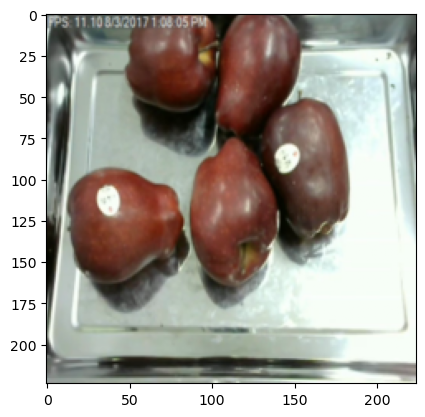

In [38]:
plt.imshow(test_data['images'][10])
plt.show()

In [29]:
# Save predictions to file
np.savetxt('test_predictions.txt', test_predictions)

In [40]:
with open('test_predictions.txt','w') as f:
    for pred in test_predictions:
        f.write(str(pred[0])+'\n')